Diffusion Model

In [1]:
import torch
torch.cuda.empty_cache()

import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\andrewmvd\animal-faces\versions\1


Simple Class to Retrieve Data

In [2]:
import torch.utils.data as utils
import os
from PIL import Image

class SimpleImageFolder(utils.Dataset):
    def __init__(self, root, transform=None):
        # save the folder root and the transform for later use
        self.root = root
        self.transform = transform

        # build a list of absolute file paths for images in the folder
        self.files = [
            os.path.join(root, f)                                 # full path: root + filename
            for f in os.listdir(root)                             # list every entry in the root folder
            if f.lower().endswith((".png", ".jpg", ".jpeg"))      # keep only files with these extensions
        ]

    def __len__(self):
        # return how many images we found — DataLoader uses this
        return len(self.files)

    def __getitem__(self, idx):
        # Get the full file path of the requested index
        img_path = self.files[idx]

        # Open the image and convert to RGB (3 channels)
        img = Image.open(img_path).convert("RGB")

        # Apply transforms (ToTensor, Normalize, etc.) if provided
        if self.transform:
            img = self.transform(img)

        # Return the processed image (usually a tensor)
        return img,0

In [3]:

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

I decided to put the same type of Data Augmentation I used in DCGAN
My computer runs an Nvidia GTX 3060, which is powerful but not powerful enough , so I had to use many techniques to save memory, the most famous one is to decrease the batch size , it makes the model slower, but it makes training doable.
My batch size is of 8 now.

In [4]:

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

train_ds_path=path+"/afhq/train/cat"

transform = transforms.Compose([
transforms.Resize((64, 64)),
transforms.RandomHorizontalFlip(),  # data augmentation
transforms.ColorJitter(hue=0.1, saturation=0.1),
transforms.ToTensor(),
transforms.Normalize([0.5], [0.5])  # map to (-1, 1)
  ])

ds = SimpleImageFolder(train_ds_path, transform=transform)
dataloader = DataLoader(ds, batch_size = 8, shuffle = True)


For the Scheduler I decided to use squared cosine , proven to be more effective than normal sinusoidal function.

In [5]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
    beta_start=0.0001,
    beta_end=0.02,
)

My Diffusion Model is fairly similar to the proffesors one. Only difference is the placement of the attention blocks, and gradient checkpoint.

My computer runs an Nvidia GTX 3060, which is powerful but not powerful enough , so I had to use many techniques to save memory, one of which is gradient Checkpointing. 

In [8]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=64,
    in_channels=3,
    out_channels=3,

    # now 4 stages: 64 → 128 → 256 → 512
    block_out_channels=(64, 128, 256, 512),

    # attention ONLY at the 32×32 stage to save VRAM
    down_block_types=(
        "DownBlock2D",        # 64x64 -> 32x32
        "AttnDownBlock2D",    # 32x32 with attention
        "DownBlock2D",        # 16x16
        "AttnDownBlock2D",        # 8x8 (no attention, cheaper)
    ),

    up_block_types=(
        "AttnUpBlock2D",          # 8x8 -> 16x16
        "UpBlock2D",          # 16x16 -> 32x32
        "AttnUpBlock2D",      # 32x32 with attention
        "UpBlock2D",          # 32x32 -> 64x64
    ),
)

# stability / VRAM tricks
model.enable_gradient_checkpointing()
model.to(device)


UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def sample_images(model, scheduler, num_samples=1):
    model.eval()

    # Create starting noise
    x = torch.randn(num_samples, 3, 64, 64).to(device)

    # Set scheduler to evaluation mode
    scheduler.set_timesteps(1000)   
    
    # Reverse diffusion: t = 999 → 0
    with torch.no_grad():
        for t in scheduler.timesteps:
            # predict the noise
            noise_pred = model(x, t).sample

            # compute x_{t-1}
            step_output = scheduler.step(noise_pred, t, x)
            x = step_output.prev_sample

    # Map from (-1,1) back to (0,1) for display
    x = (x.clamp(-1, 1) + 1) / 2
    return x

To making the model faster, more effective, and reduce its space complexity, I set my gradients to FP16, and introduced a Gradient Scaler. 
Basically Using Automatic Mixed Precision.
I increased the number of epochs to 150, in the hopes the model would do better

C:\Users\user\AppData\Local\Temp\ipykernel_44236\1292844893.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
C:\Users\user\AppData\Local\Temp\ipykernel_44236\1292844893.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


Epoch 0: loss = 0.0428
Epoch 1: loss = 0.1255
Epoch 2: loss = 0.0132
Epoch 3: loss = 0.0083
Epoch 4: loss = 0.0068
Epoch 5: loss = 0.0708
Epoch 6: loss = 0.0255
Epoch 7: loss = 0.0266
Epoch 8: loss = 0.0403
Epoch 9: loss = 0.0038
Epoch 10: loss = 0.0183
Epoch 11: loss = 0.0698
Epoch 12: loss = 0.1012
Epoch 13: loss = 0.0077
Epoch 14: loss = 0.0034
Epoch 15: loss = 0.0156
Epoch 16: loss = 0.0157
Epoch 17: loss = 0.0353
Epoch 18: loss = 0.0112
Epoch 19: loss = 0.0149
Epoch 20: loss = 0.0376
Epoch 21: loss = 0.0200
Epoch 22: loss = 0.1415
Epoch 23: loss = 0.1963
Epoch 24: loss = 0.0014
Epoch 25: loss = 0.2089


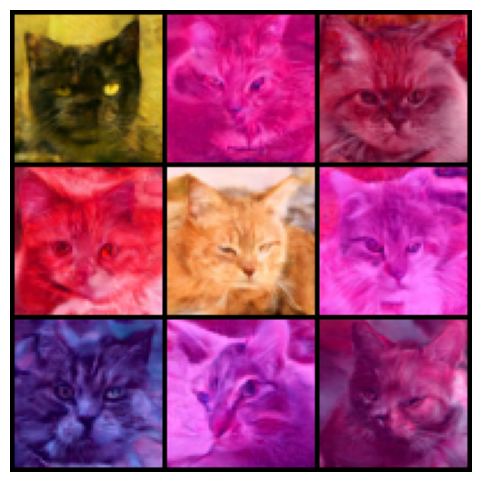

Epoch 26: loss = 0.0773
Epoch 27: loss = 0.0174
Epoch 28: loss = 0.0353
Epoch 29: loss = 0.0328
Epoch 30: loss = 0.1197
Epoch 31: loss = 0.0283
Epoch 32: loss = 0.1082
Epoch 33: loss = 0.3146
Epoch 34: loss = 0.0126
Epoch 35: loss = 0.0785
Epoch 36: loss = 0.0154
Epoch 37: loss = 0.0055
Epoch 38: loss = 0.0039
Epoch 39: loss = 0.0027
Epoch 40: loss = 0.4444
Epoch 41: loss = 0.0125
Epoch 42: loss = 0.0004
Epoch 43: loss = 0.0559
Epoch 44: loss = 0.0120
Epoch 45: loss = 0.0317
Epoch 46: loss = 0.0139
Epoch 47: loss = 0.0460
Epoch 48: loss = 0.0041
Epoch 49: loss = 0.0092
Epoch 50: loss = 0.0021


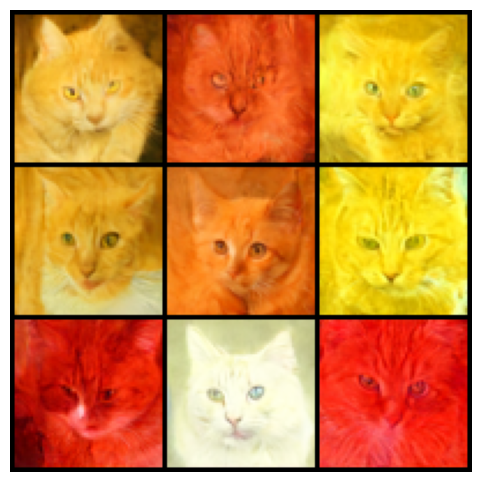

Epoch 51: loss = 0.0013
Epoch 52: loss = 0.0080
Epoch 53: loss = 0.0071
Epoch 54: loss = 0.0029
Epoch 55: loss = 0.0401
Epoch 56: loss = 0.0678
Epoch 57: loss = 0.0019
Epoch 58: loss = 0.0780
Epoch 59: loss = 0.0170
Epoch 60: loss = 0.0163
Epoch 61: loss = 0.0099
Epoch 62: loss = 0.1180
Epoch 63: loss = 0.0321
Epoch 64: loss = 0.0077
Epoch 65: loss = 0.0004
Epoch 66: loss = 0.0077
Epoch 67: loss = 0.0009
Epoch 68: loss = 0.0068
Epoch 69: loss = 0.0471
Epoch 70: loss = 0.0166
Epoch 71: loss = 0.0021
Epoch 72: loss = 0.0709
Epoch 73: loss = 0.0738
Epoch 74: loss = 0.0009
Epoch 75: loss = 0.0281


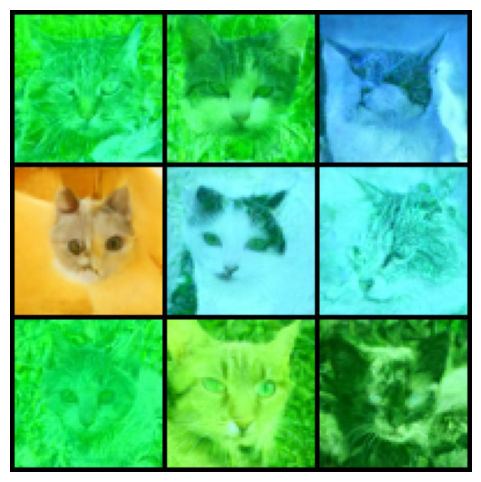

Epoch 76: loss = 0.0402
Epoch 77: loss = 0.0331
Epoch 78: loss = 0.0101
Epoch 79: loss = 0.0088
Epoch 80: loss = 0.0344
Epoch 81: loss = 0.0028
Epoch 82: loss = 0.0073
Epoch 83: loss = 0.0069
Epoch 84: loss = 0.0011
Epoch 85: loss = 0.0354
Epoch 86: loss = 0.0618
Epoch 87: loss = 0.0008
Epoch 88: loss = 0.0324
Epoch 89: loss = 0.0279
Epoch 90: loss = 0.0085
Epoch 91: loss = 0.0292
Epoch 92: loss = 0.0899
Epoch 93: loss = 0.0333
Epoch 94: loss = 0.0109
Epoch 95: loss = 0.0124
Epoch 96: loss = 0.0128
Epoch 97: loss = 0.0032
Epoch 98: loss = 0.0321
Epoch 99: loss = 0.0539
Epoch 100: loss = 0.0112


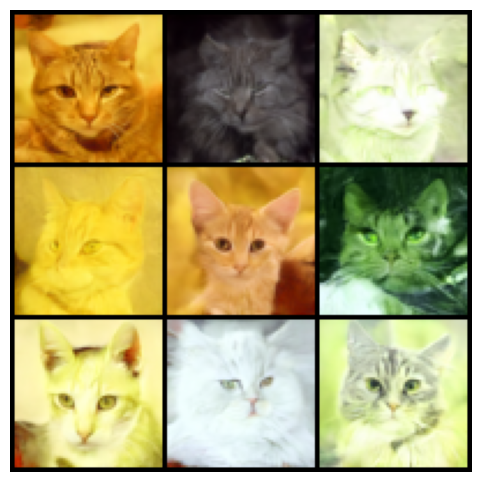

Epoch 101: loss = 0.0048
Epoch 102: loss = 0.0179
Epoch 103: loss = 0.0011
Epoch 104: loss = 0.0017
Epoch 105: loss = 0.0388
Epoch 106: loss = 0.3739
Epoch 107: loss = 0.0405
Epoch 108: loss = 0.0075
Epoch 109: loss = 0.0027
Epoch 110: loss = 0.0143
Epoch 111: loss = 0.0423
Epoch 112: loss = 0.0044
Epoch 113: loss = 0.0377
Epoch 114: loss = 0.0363
Epoch 115: loss = 0.0044
Epoch 116: loss = 0.0974
Epoch 117: loss = 0.0344
Epoch 118: loss = 0.0379
Epoch 119: loss = 0.0067
Epoch 120: loss = 0.0094
Epoch 121: loss = 0.0183
Epoch 122: loss = 0.0344
Epoch 123: loss = 0.0199
Epoch 124: loss = 0.0407
Epoch 125: loss = 0.0013


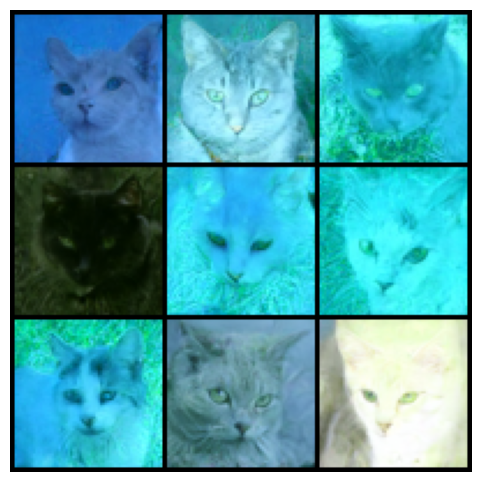

Epoch 126: loss = 0.0044
Epoch 127: loss = 0.0026
Epoch 128: loss = 0.0054
Epoch 129: loss = 0.0344
Epoch 130: loss = 0.0238
Epoch 131: loss = 0.0065
Epoch 132: loss = 0.0566
Epoch 133: loss = 0.0903
Epoch 134: loss = 0.0024
Epoch 135: loss = 0.0206
Epoch 136: loss = 0.0071
Epoch 137: loss = 0.0507
Epoch 138: loss = 0.1605
Epoch 139: loss = 0.0875
Epoch 140: loss = 0.0161
Epoch 141: loss = 0.3588
Epoch 142: loss = 0.0111
Epoch 143: loss = 0.0436
Epoch 144: loss = 0.1285
Epoch 145: loss = 0.0406
Epoch 146: loss = 0.0075
Epoch 147: loss = 0.0042
Epoch 148: loss = 0.0083
Epoch 149: loss = 0.0164


In [10]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

num_epochs = 150
losses = []

for epoch in range(num_epochs):
    for batch in dataloader:
        clean_images = batch[0].to(device)
        noise = torch.randn_like(clean_images)

        timesteps = torch.randint(
            0,
            scheduler.num_train_timesteps,
            (clean_images.size(0),),
            device=device,
        ).long()

        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        optimizer.zero_grad()

        # 🚀 Mixed precision
        with autocast(dtype=torch.float16):
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        # 🚀 Scale + backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())


    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

    # -----------------------------
    #   SAMPLE EVERY 25 EPOCHS
    # -----------------------------
    if epoch % 25 == 0 and epoch != 0:
        torch.cuda.empty_cache()
        model.eval()

        with torch.no_grad():
            samples = sample_images(model, scheduler, num_samples=9)

        from torchvision.utils import make_grid
        grid = make_grid(samples, nrow=3)

        plt.figure(figsize=(6,6))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        plt.show()


Plot The Losses

Text(0.5, 0, 'Training step')

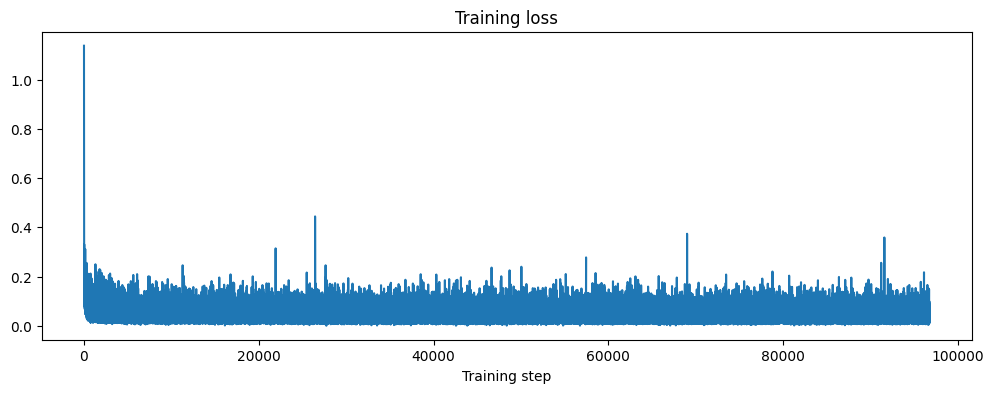

In [11]:
from matplotlib import pyplot as plt

plt.subplots(1, 1, figsize=(12, 4))

plt.subplot(1, 1, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

In here I do a simple Sampling

In [12]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def sample_images(model, scheduler, num_samples=1):
    model.eval()

    # Create starting noise
    x = torch.randn(num_samples, 3, 64, 64).to(device)

    # Set scheduler to evaluation mode
    scheduler.set_timesteps(1000)   
    
    # Reverse diffusion: t = 999 → 0
    with torch.no_grad():
        for t in scheduler.timesteps:
            # predict the noise
            noise_pred = model(x, t).sample

            # compute x_{t-1}
            step_output = scheduler.step(noise_pred, t, x)
            x = step_output.prev_sample

    # Map from (-1,1) back to (0,1) for display
    x = (x.clamp(-1, 1) + 1) / 2
    return x

Here I Show the Images

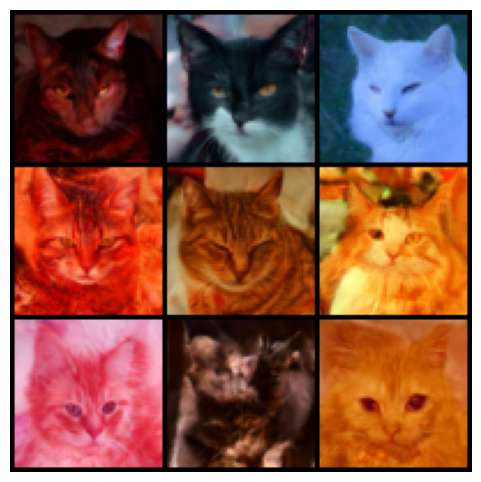

In [13]:
samples = sample_images(model, scheduler, num_samples=9)

grid = make_grid(samples, nrow=3)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()